## Notebook to prepare the ROMS output data from Tim to be able to save the datasets locally

The next step would be to create the datasets for lateral forcing.

In this notebook:
- Datetime objects are changed into years


The ROMS output data from tim is:
- 1993-2018
- Yearly
- 1/8°x1/8°,

The data is downloaded from: http://doi.org/10.4121/uuid:d9656541-ff40-45d0-8859-ac644b155dfb



 

In [1]:
# Import necessary packages

import ast
import numpy as np
import xarray as xr

from tqdm import tqdm

In [2]:
# Import ROMS output from tim
roms_output_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Tim/model_output/Exp_AllVar_noSLP/NorthSea8_avg_zeta_timeseries_annual.nc')

# Obtain years
roms_output_tim = roms_output_tim.groupby('ocean_time.year').mean()

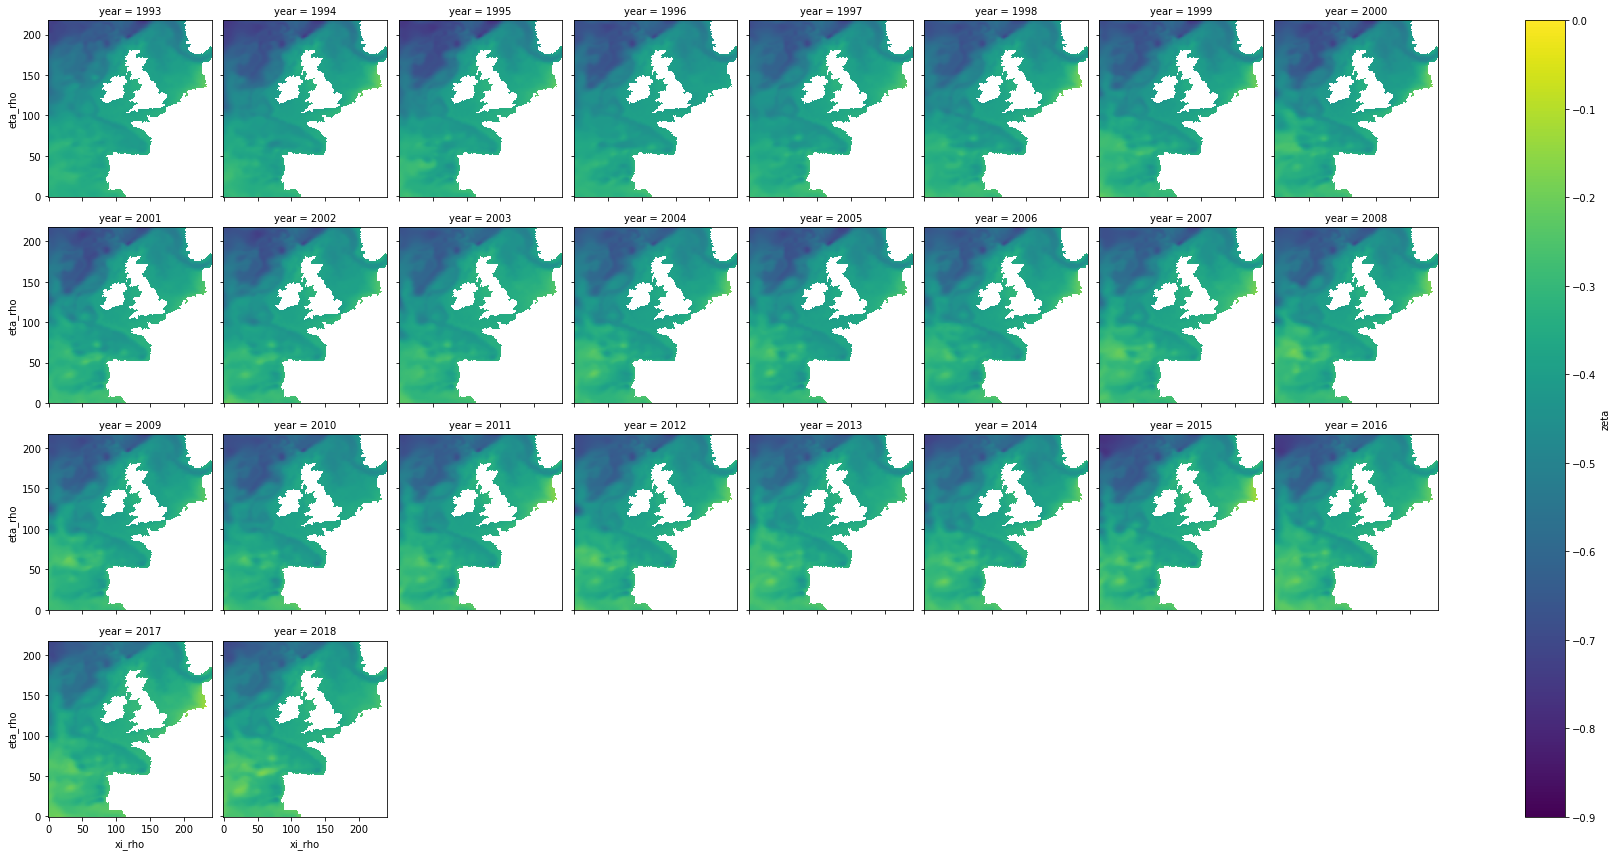

In [3]:
roms_output_tim.zeta.plot(col = 'year', col_wrap = 8, vmin = -0.9, vmax = 0) # Sea level [m]

#### Obtain dictionaries to transfrom x,y to lat,lon

In [15]:
lats = [lst[0] for lst in roms_output_tim.lat_rho.values]
lons = list(roms_output_tim.lon_rho.values[0])


In [176]:
ROMS_output_tim = xr.Dataset(
    data_vars = dict(
        slh = (["year", "lat", "lon"], roms_output_tim.zeta.values)
    ),
    coords = dict(
        year = (["year"], years),
        lat = (["lat"], lats),
        lon = (["lon"], lons),
    ),
    attrs = dict(
        description = "ROMS slh output from Tim",
    )    
)
    
ROMS_output_tim.slh.attrs['units'] = "m"
ROMS_output_tim.slh.attrs['long name'] = "Sea level height above the geoid"

  0%|                                                    | 0/26 [11:25<?, ?it/s]


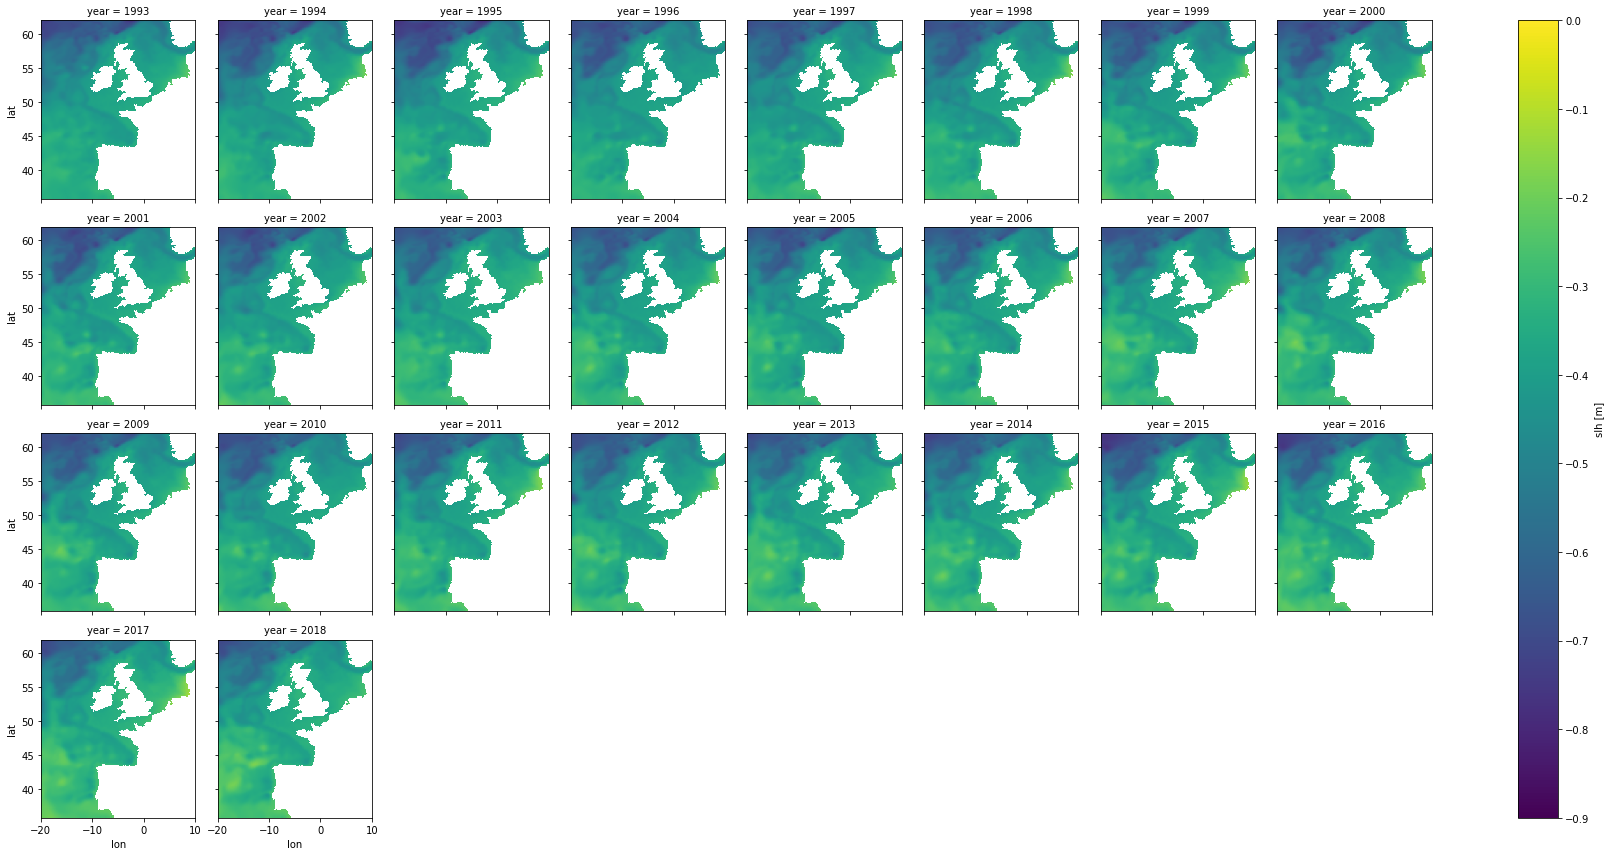

In [178]:
ROMS_output_tim.slh.plot(col = 'year', col_wrap = 8, vmin = -0.9, vmax = 0) # Sea level [m]

In [179]:
# Save the dataset
ROMS_output_tim.to_netcdf(f"/Users/iriskeizer/Documents/ROMS/data/Tim/ROMS_output_tim.nc")

In [ ]:
roms_output_tim.

In [168]:
roms_output_tim.eta_rho.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [164]:
coord_dict_ll = {}


for eta_rho in tqdm(roms_output_tim.eta_rho.values):
    for xi_rho in roms_output_tim.xi_rho.values:
        
        data = roms_output_tim.loc[dict(eta_rho = eta_rho, xi_rho = xi_rho)]
        
        lat = float(data.lat_rho)
        lon = float(data.lon_rho)
        
        coord_dict_ll[(lat, lon)] = (eta_rho, xi_rho)
        


100%|█████████████████████████████████████████| 218/218 [00:11<00:00, 19.71it/s]


In [165]:
len(coord_dict_ll)

52756

In [100]:
# open file for writing
f = open("/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/Conversion dictionaries/coord_dict_ll.txt","w")

# write file
f.write( str(coord_dict_ll) )

# close file
f.close()



#### Create new dataset with lat and lon as dimensions

In [101]:
# Import conversion dictionaries
f_ll = open(r"/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/Conversion dictionaries/coord_dict_ll.txt","r")

f_ll = f_ll.read()

In [102]:
coord_dict_ll = ast.literal_eval(f_ll)

In [151]:
# Change the GLORYS2V3 dataset currently having dimensions (year, y, x) into an array having dimensions (year, lat, lon)
years = roms_output_tim.year.values

def action(lat, lon, year):
    
    eta_rho, xi_rho = coord_dict_ll[lat, lon]
    
    return float(roms_output_tim.loc[dict(eta_rho = eta_rho, xi_rho = xi_rho, year = year)].zeta)
    
    
slh_arr = [[[action(lat, lon, year) if (lat,lon) in coord_dict_ll else np.nan for lon in lons] for lat in lats] for year in tqdm(years)]


100%|███████████████████████████████████████████| 26/26 [00:01<00:00, 15.89it/s]


In [152]:
ROMS_output_tim = xr.Dataset(
    data_vars = dict(
        slh = (["year", "lat", "lon"], slh_arr)
    ),
    coords = dict(
        year = (["year"], years),
        lat = (["lat"], lats),
        lon = (["lon"], lons),
    ),
    attrs = dict(
        description = "ROMS slh output from Tim",
    )    
)
    
ROMS_output_tim.slh.attrs['units'] = "m"
ROMS_output_tim.slh.attrs['long name'] = "Sea level height above the geoid"

In [153]:
ROMS_output_tim

<xarray.Dataset>
Dimensions:  (year: 26, lat: 218, lon: 242)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017 2018
  * lat      (lat) float64 35.88 36.03 36.18 36.33 ... 61.69 61.78 61.87 61.96
  * lon      (lon) float64 -19.94 -19.81 -19.69 -19.57 ... 9.69 9.814 9.938
Data variables:
    slh      (year, lat, lon) float64 -0.3362 nan nan nan ... nan nan nan nan
Attributes:
    description:  ROMS slh output from Tim

In [148]:
ROMS_output_tim = ROMS_output_tim.sortby('lat')
ROMS_output_tim = ROMS_output_tim.sortby('lon')

In [177]:
ROMS_output_tim

<xarray.Dataset>
Dimensions:  (year: 26, lat: 218, lon: 242)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017 2018
  * lat      (lat) float64 35.88 36.03 36.18 36.33 ... 61.69 61.78 61.87 61.96
  * lon      (lon) float64 -19.94 -19.81 -19.69 -19.57 ... 9.69 9.814 9.938
Data variables:
    slh      (year, lat, lon) float32 -0.3362 -0.3362 -0.3355 ... nan nan nan
Attributes:
    description:  ROMS slh output from Tim

In [174]:
len(lats)

218